### A. Import dữ liệu cần thiết

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
trending_videos = pd.read_csv('Data/trending_videos.csv').iloc[:, 1:]

pd.options.display.float_format = '{:,.0f}'.format
# pd.options.display.float_format = None

In [5]:
trending_videos = pd.read_csv('Data/trending_videos.csv')

### B. Trực quan hoá

#### 1. Phân tích thống kê tổng quan

##### a. Lượt xem, lượt thích, bình luận

In [6]:
# Xác định bảng gồm các chỉ số thống kê
# của Lượt xem, lượt thích, bình luận 
general_trending_videos = trending_videos[["view_count", "like_count", "comment_count"]]

general_trending_videos.describe()


,view_count,like_count,comment_count
count,"17,512","17,512","17,512"
mean,"16,631,531","440,410","5,097"
std,"29,073,052","1,001,456","22,914"
min,"187,782",0,0
25%,"1,703,761","28,766",135
50%,"3,495,725","63,612",427
75%,"17,990,534","323,578","2,064"
max,"290,801,447","11,040,218","438,822"


In [7]:
#lọc dữ liệu để vẽ đồ thị
general_month = trending_videos.loc[::, ["snapshot_date", "view_count", "like_count", "comment_count"]]

general_month['snapshot_date'] = pd.to_datetime(general_month['snapshot_date'])
general_month['snapshot_date'] = general_month['snapshot_date'].dt.to_period('M')
general_month = general_month.groupby('snapshot_date').mean().reset_index()

general_month

,snapshot_date,view_count,like_count,comment_count
0,2023-11,"7,774,582","209,155","7,430"
1,2023-12,"8,396,831","247,525","3,497"
2,2024-01,"11,770,799","308,438","2,803"
3,2024-02,"16,946,634","421,504","3,429"
4,2024-03,"19,947,261","515,162","6,439"
5,2024-04,"18,610,296","520,917","4,341"
6,2024-05,"22,734,065","600,849","3,302"
7,2024-06,"20,153,998","526,412","6,100"
8,2024-07,"21,877,066","660,230","9,501"
9,2024-08,"16,164,299","434,596","6,374"


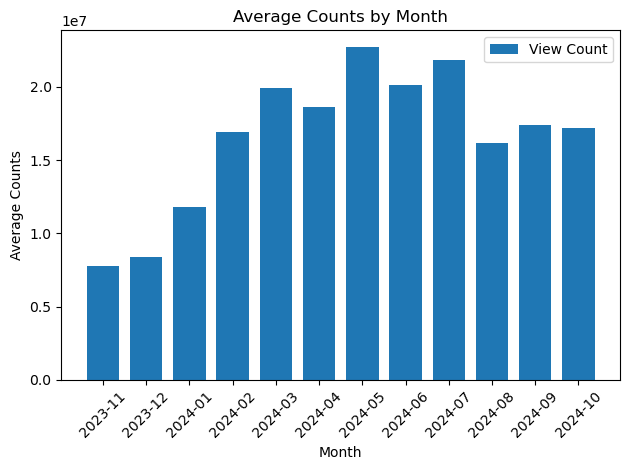

In [8]:
# vẽ các đồ thị thể hiện phân bố của lượt xem, lượt thích, bình luận (làm tròn theo 1000)
#ví dụ 
x = range(len(general_month['snapshot_date']))
width = 0.75

plt.bar(x, general_month['view_count'], width=width, label='View Count')
# Thêm nhãn và tiêu đề
plt.xticks(x, general_month['snapshot_date'].astype(str), rotation=45)
plt.xlabel('Month')
plt.ylabel('Average Counts')
plt.title('Average Counts by Month')
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

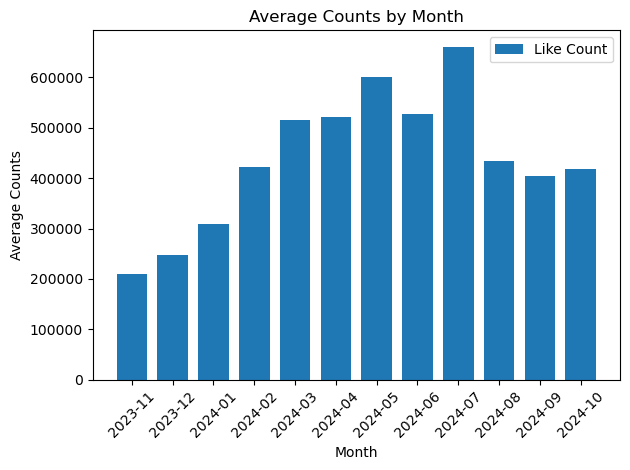

In [9]:
# vẽ các đồ thị thể hiện phân bố của lượt xem, lượt thích, bình luận (làm tròn theo 1000)
#ví dụ 
x = range(len(general_month['snapshot_date']))
width = 0.75

plt.bar(x, general_month['like_count'], width=width, label='Like Count')

# Thêm nhãn và tiêu đề
plt.xticks(x, general_month['snapshot_date'].astype(str), rotation=45)
plt.xlabel('Month')
plt.ylabel('Average Counts')
plt.title('Average Counts by Month')
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

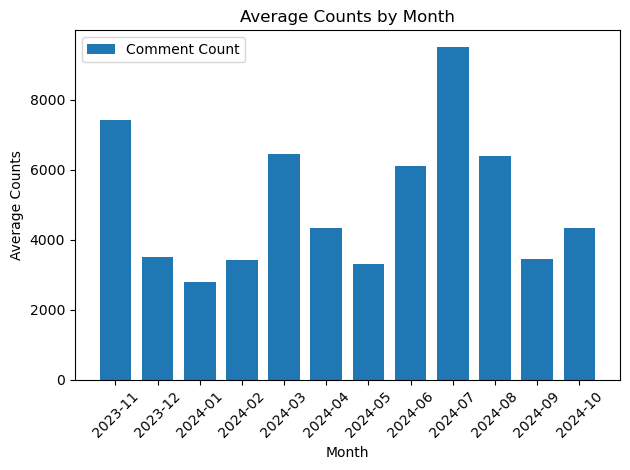

In [10]:
# vẽ các đồ thị thể hiện phân bố của lượt xem, lượt thích, bình luận (làm tròn theo 1000)
#ví dụ 
x = range(len(general_month['snapshot_date']))
width = 0.75

plt.bar(x, general_month['comment_count'], width=width, label='Comment Count')

# Thêm nhãn và tiêu đề
plt.xticks(x, general_month['snapshot_date'].astype(str), rotation=45)
plt.xlabel('Month')
plt.ylabel('Average Counts')
plt.title('Average Counts by Month')
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [11]:
#=> phân bố của các chỉ số
pd.options.display.float_format = None
general_month['like_to_view'] = (general_month['like_count'] / general_month['view_count']) * 100
general_month.loc[..., ['snapshot_date', 'like_to_view']]

,snapshot_date,like_to_view
0,2023-11,2.690237
1,2023-12,2.947843
2,2024-01,2.620366
3,2024-02,2.487242
4,2024-03,2.582621
5,2024-04,2.799082
6,2024-05,2.642945
7,2024-06,2.611949
8,2024-07,3.017908
9,2024-08,2.688614


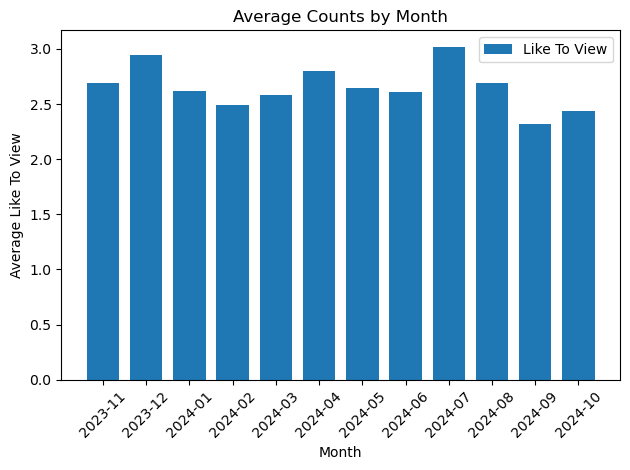

In [12]:
x = range(len(general_month['snapshot_date']))
width = 0.75

plt.bar(x, general_month['like_to_view'], width=width, label='Like To View')

# Thêm nhãn và tiêu đề
plt.xticks(x, general_month['snapshot_date'].astype(str), rotation=45)
plt.xlabel('Month')
plt.ylabel('Average Like To View')
plt.title('Average Counts by Month')
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

##### b. Thời lượng video

In [13]:
#xác định các chỉ số thống kê của thời lượng video


In [14]:
# xác định bảng gồm phần trăm theo thời lượng video (dưới 1p, 5 phút, 5–10 phút, trên 10 phút)
# và số video của thời lượng đó theo mốc thời gian 1 tháng 

# Ensure 'month_year' column is created
trending_videos['snapshot_date'] = pd.to_datetime(trending_videos['snapshot_date'])
trending_videos['month_year'] = trending_videos['snapshot_date'].dt.to_period('M')

# Convert duration to timedelta
trending_videos['duration'] = pd.to_timedelta(trending_videos['duration'])

# Define duration categories
bins = [pd.Timedelta(minutes=0), pd.Timedelta(minutes=1), pd.Timedelta(minutes=10), pd.Timedelta(minutes=60), pd.Timedelta(hours=24)]
labels = ['<1 min', '1-10 min', '10-60 min', '>60 min']

# Categorize durations
trending_videos['duration_category'] = pd.cut(trending_videos['duration'], bins=bins, labels=labels, right=False)

# Group by month and duration category
duration_df = trending_videos.groupby(['month_year', 'duration_category']).size().unstack(fill_value=0)

# Calculate percentage
duration_percentage = duration_df.div(duration_df.sum(axis=1), axis=0) * 100

# print(duration_df)
print(duration_percentage)

duration_category     <1 min   1-10 min  10-60 min    >60 min
month_year                                                   
2023-11            31.545961  29.526462  12.047354  26.880223
2023-12            53.255655  19.945168  10.006854  16.792324
2024-01            60.847701  15.229885   8.405172  15.517241
2024-02            73.980726  14.529281   2.149741   9.340252
2024-03            67.859699  20.615605   4.008590   7.516106
2024-04            73.614958  15.443213   5.955679   4.986150
2024-05            77.741514  10.248042   5.026110   6.984334
2024-06            68.101093  17.486339   9.153005   5.259563
2024-07            61.167002  18.645205   3.554661  16.633132
2024-08            59.646828  14.846305   4.774362  20.732505
2024-09            66.167461  10.347175   3.199455  20.285909
2024-10            69.741935  10.516129   2.193548  17.548387


C:\Users\Admin\AppData\Local\Temp\ipykernel_10800\1435976642.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_df = trending_videos.groupby(['month_year', 'duration_category']).size().unstack(fill_value=0)


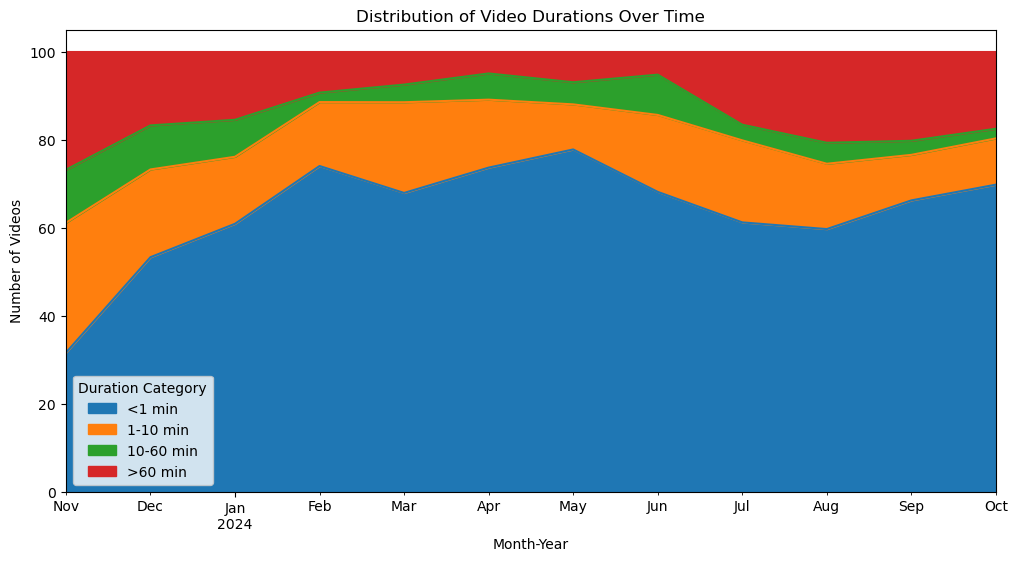

In [15]:
duration_percentage.plot(kind='area', figsize=(12, 6), stacked=True)
plt.title('Distribution of Video Durations Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Videos')
plt.legend(title='Duration Category')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_10800\29683259.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  duration_category_pivot = trending_videos.pivot_table(index='category', columns='duration_category', aggfunc='size', fill_value=0)


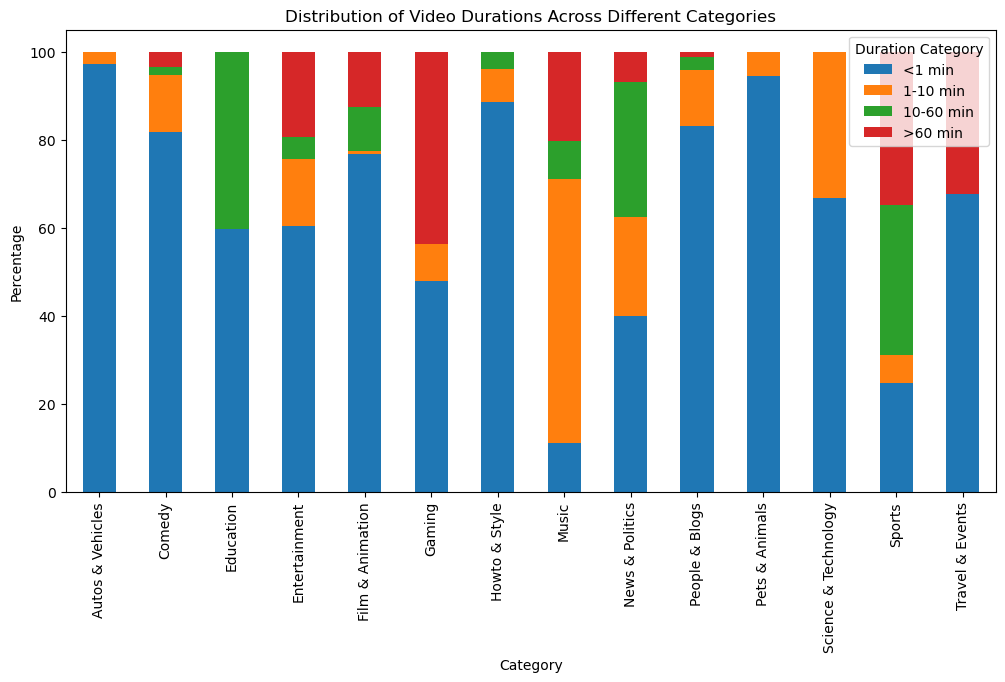

In [16]:
# Create a pivot table to analyze the distribution of video durations across different categories
duration_category_pivot = trending_videos.pivot_table(index='category', columns='duration_category', aggfunc='size', fill_value=0)

# Normalize the pivot table to get the percentage distribution
duration_category_percentage = duration_category_pivot.div(duration_category_pivot.sum(axis=1), axis=0) * 100

# Plot the distribution
duration_category_percentage.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Distribution of Video Durations Across Different Categories')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.legend(title='Duration Category')
plt.show()

In [17]:
#=> Video thời lượng bao nhiêu dễ đạt trending nhất?

##### c. Thời gian đạt trending và tồn tại trong trending

In [20]:
trending_videos = pd.read_csv('Data/trending_videos.csv').iloc[::,1:]
trending_videos['snapshot_date'] = pd.to_datetime(trending_videos['snapshot_date'])
trending_videos['month_year'] = trending_videos['snapshot_date'].dt.to_period('M')

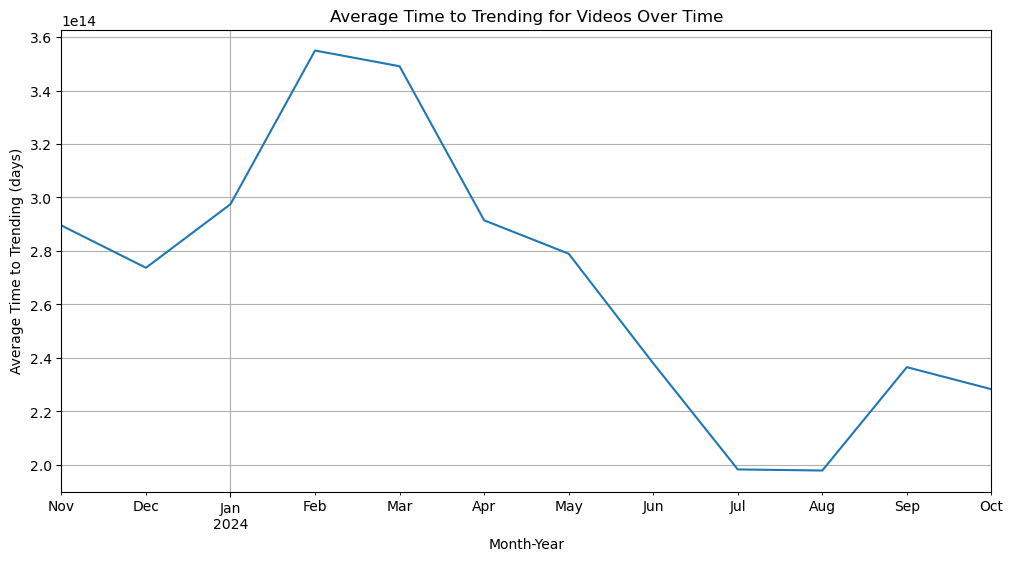

In [21]:
# Convert 'time_to_trending' to timedelta
trending_videos['time_to_trending'] = pd.to_timedelta(trending_videos['time_to_trending'])

# Calculate the average time to trending for each month
avg_time_to_trending = trending_videos.groupby('month_year')['time_to_trending'].mean()

# Plot the average time to trending
avg_time_to_trending.plot(kind='line', figsize=(12, 6))
plt.title('Average Time to Trending for Videos Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Average Time to Trending (days)')
plt.grid(True)
plt.show()

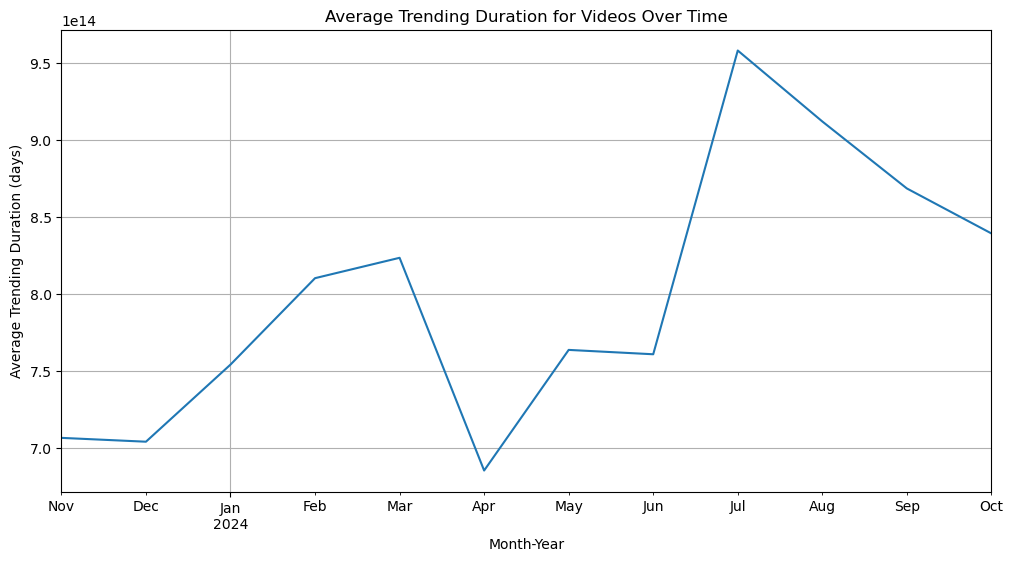

In [22]:
# Calculate the duration each video stays in the trending list
trending_videos['trending_duration'] = trending_videos.groupby('video_id')['snapshot_date'].transform(lambda x: x.max() - x.min())

# Calculate the average trending duration for each month
avg_trending_duration = trending_videos.groupby('month_year')['trending_duration'].mean()

# Plot the average trending duration
avg_trending_duration.plot(kind='line', figsize=(12, 6))
plt.title('Average Trending Duration for Videos Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Average Trending Duration (days)')
plt.grid(True)
plt.show()

In [23]:
# phan 2

In [24]:
trending_videos = pd.read_csv('Data/trending_videos.csv')
trending_videos = trending_videos[['snapshot_date', 'category']]
trending_videos['category'] = trending_videos['category'].fillna('Unknown')
category_counts = trending_videos['category'].value_counts()
trending_videos['category'] = trending_videos['category'].apply(lambda x: x if category_counts[x] >= 800 else 'Others')
trending_videos = trending_videos.groupby(['snapshot_date', 'category']).size().unstack(fill_value=0)
trending_videos.index = pd.to_datetime(trending_videos.index)
trending_videos['month'] = trending_videos.index.to_period('M')
monthly_data = trending_videos.groupby('month').sum()
# monthly_data

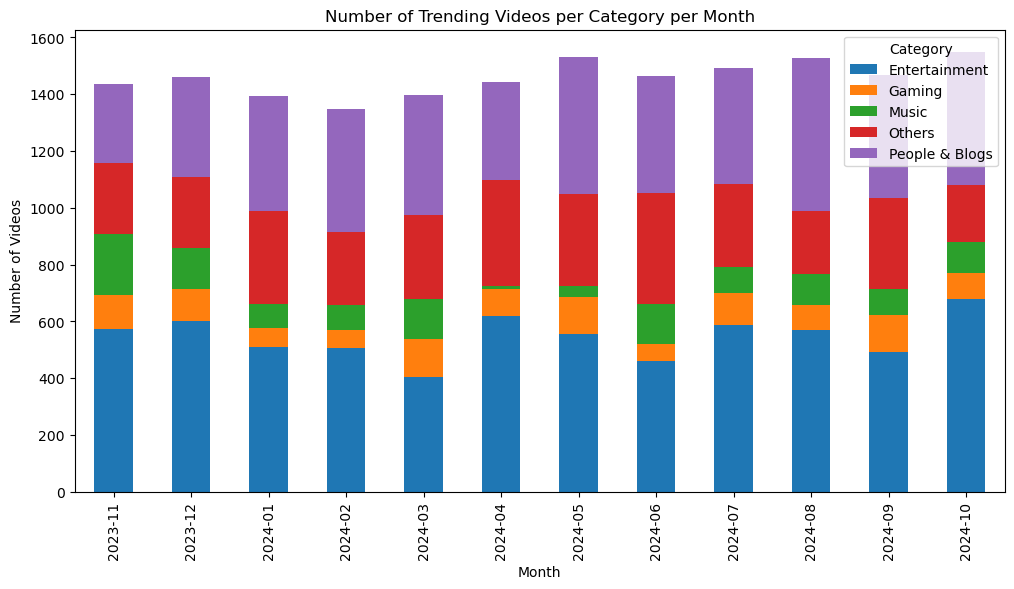

In [25]:
monthly_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Number of Trending Videos per Category per Month')
plt.xlabel('Month')
plt.ylabel('Number of Videos')
plt.legend(title='Category')
plt.show()

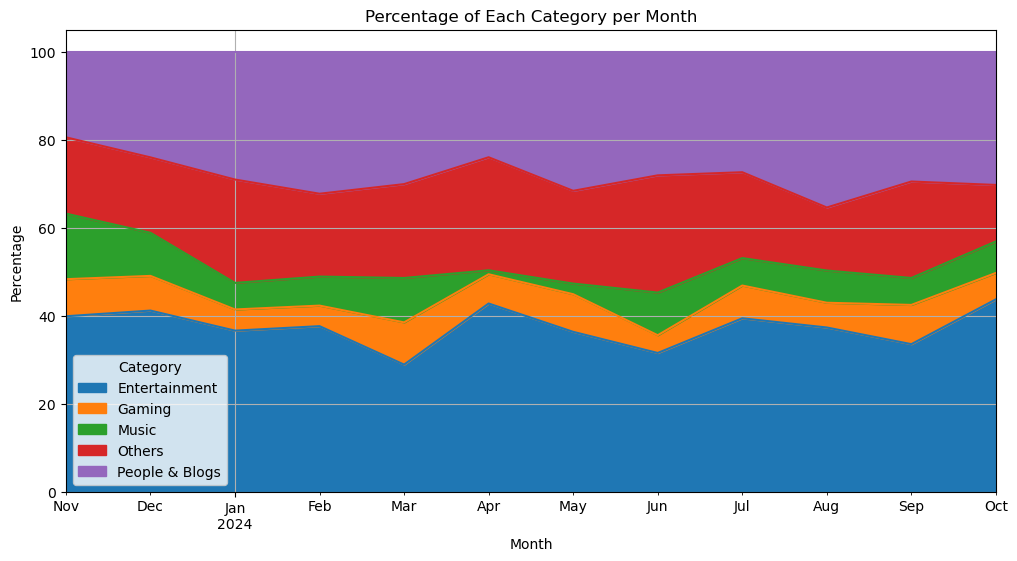

In [26]:
category_percentage = monthly_data.div(monthly_data.sum(axis=1), axis=0) * 100
category_percentage.plot(kind='area', figsize=(12, 6), stacked=True)
plt.title('Percentage of Each Category per Month')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.legend(title='Category')
plt.grid(True, axis='both')
plt.show()

In [27]:
trending_videos = pd.read_csv('Data/trending_videos.csv')

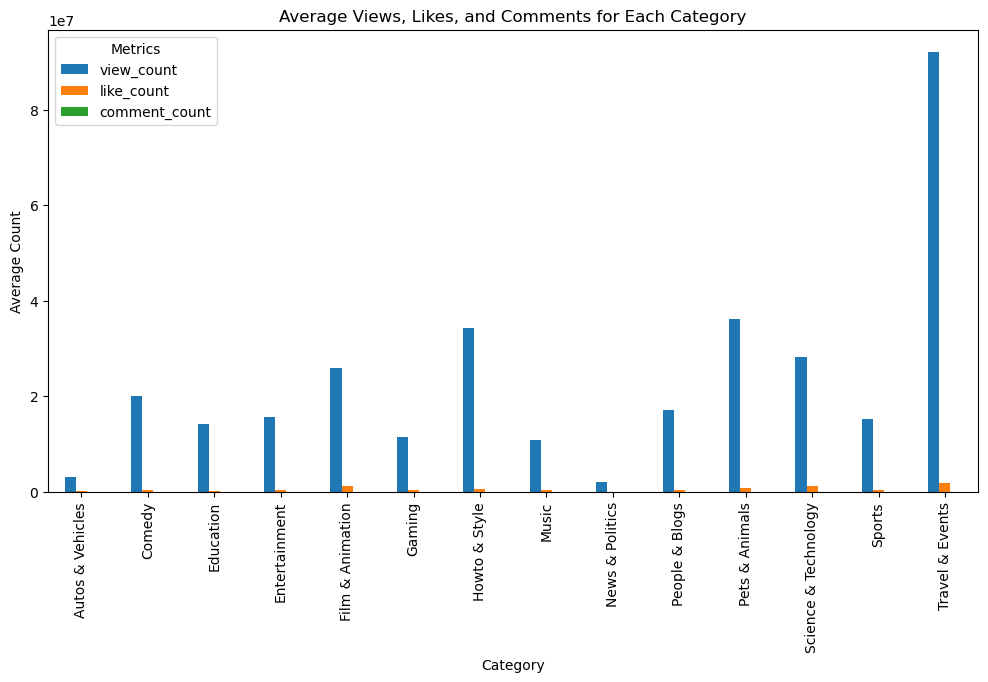

In [28]:
# Calculate the average views, likes, and comments for each category
avg_views_likes_comments = trending_videos.groupby('category')[['view_count', 'like_count', 'comment_count']].mean()

# Plot the average views, likes, and comments for each category
avg_views_likes_comments.plot(kind='bar', figsize=(12, 6))
plt.title('Average Views, Likes, and Comments for Each Category')
plt.xlabel('Category')
plt.ylabel('Average Count')
plt.legend(title='Metrics')
plt.show()

##### b. Biểu đồ thể hiện tỉ trọng của các chủ đề video

In [31]:
trending_videos = pd.read_csv('Data/trending_videos.csv')
trending_videos = trending_videos[['snapshot_date', 'category']]
trending_videos['category'] = trending_videos['category'].fillna('Unknown')
category_counts = trending_videos['category'].value_counts()
trending_videos['category'] = trending_videos['category'].apply(lambda x: x if category_counts[x] >= 800 else 'Others')
trending_videos = trending_videos.groupby(['snapshot_date', 'category']).size().unstack(fill_value=0)
trending_videos.index = pd.to_datetime(trending_videos.index)
trending_videos['month'] = trending_videos.index.to_period('M')
monthly_data = trending_videos.groupby('month').sum()
# monthly_data

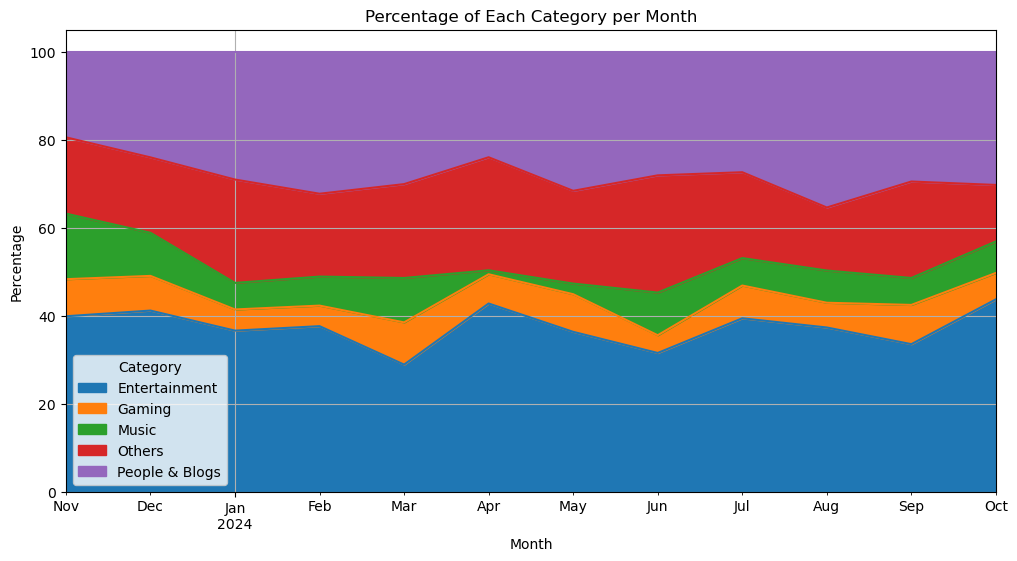

In [32]:
category_percentage = monthly_data.div(monthly_data.sum(axis=1), axis=0) * 100
category_percentage.plot(kind='area', figsize=(12, 6))
plt.title('Percentage of Each Category per Month')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.legend(title='Category')
plt.grid(True,axis='both')
plt.show()